In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from soccertrack import load_df
from pathlib import Path

dataset_paths = sorted([
    Path('/Users/atom/Github/TeamTrack/data/F_Basketball_Tokai/annotations'), 
    Path('/Users/atom/Github/TeamTrack/data/F_Handball_Nagoya_undistorted/annotations'), 
    Path('/Users/atom/Github/TeamTrack/data/F_Soccer_Tsukuba3/annotations')
])

In [15]:
import json
import cv2
import numpy as np
import pandas as pd
from ast import literal_eval

from soccertrack.logger import logger, set_log_level
from soccertrack import CoordinatesDataFrame

def read_json(path):
    with open(path, "r") as f:
        return json.load(f)


def warp_bbox_to_point(H, bbox):
    x, y, w, h = bbox
    # point = np.array([[x + w / 2, y + h / 2]]).T
    point = np.array([[x + w / 2, y + h]]).T
    
    point = cv2.perspectiveTransform(point.reshape(1, 1, 2), H).squeeze()
    series = pd.Series(point)
    series = series.rename({0: "x", 1: "y"})
    return series

def bbdf_to_codf(bbdf, H):
    results = []
    
    # make sure the order of the attribute columns are correct
    bbdf = bbdf.reindex(["bb_left", "bb_top", "bb_width", "bb_height"], level="Attributes", axis=1)
    
    for i in bbdf.index:
        groups = bbdf[bbdf.index == i].groupby(level=(0, 1), axis=1)
        xy_series = groups.apply(lambda x: warp_bbox_to_point(H, x.squeeze().values[:4])).unstack()
        results.append(xy_series)
        
    _codf = pd.DataFrame(results)
    _codf.rename_axis(["TeamID", "PlayerID", "Attributes"], axis=1, inplace=True)
    _codf.index.name = "frame"
    # _codf.rename(columns={'3':'ball', '1':1, '0': 0}, inplace=True)

    codf = CoordinatesDataFrame(_codf)
    
    return codf

def calculate_homography(mapping):
    source_keypoints, target_keypoints = [], []

    for key, value in mapping.items():
        source_keypoint = value
        target_keypoint = literal_eval(key)
        source_keypoints.append(source_keypoint)
        target_keypoints.append(target_keypoint)
    source_keypoints = np.array(source_keypoints)
    target_keypoints = np.array(target_keypoints)
    
    H, *_ = cv2.findHomography(
            source_keypoints, target_keypoints, cv2.RANSAC, 5.0
        )
    
    projected_source_keypoints = cv2.perspectiveTransform(source_keypoints.reshape(-1,1,2), H).squeeze()
    projection_error = np.linalg.norm(projected_source_keypoints - target_keypoints, axis=1).mean()
    
    logger.debug(f"Projection error: {projection_error}")
    if projection_error > 1:
        logger.warning(f"Projection error is high(>1): {projection_error}")
    
    return H

def chunk_sequence(seq, chunk_size, overlap):
    step = int(chunk_size * overlap)
    chunks = [seq[i : i + chunk_size] for i in range(0, len(seq), step)]
    if len(chunks[-1]) == chunk_size:
        return chunks
    return chunks[:-1]


elements = list(range(900))
chunk_size = 240
overlap = 0.05

chunks = chunk_sequence(elements, chunk_size, overlap)
len(list(chunks)[-1])


24

In [16]:
# print(dataset_paths)
# dataset_path = dataset_paths[-1]

# trajectory_dataset_path = Path('/Users/atom/Github/TeamTrack/data/trajectory_dataset')
# sport_mapping = {
#     'F_Basketball_Tokai': 'basketball',
#     'F_Handball_Nagoya_undistorted': 'handball',
#     'F_Soccer_Tsukuba3': 'soccer'
# }

# for dataset_path in dataset_paths:
#     sport = sport_mapping[dataset_path.parent.name]

#     mapping = read_json(f"/Users/atom/Github/TeamTrack/data/{sport}_keypoints.json")
#     H = calculate_homography(mapping)
#     csv_paths = sorted(dataset_path.glob('*.csv'))

#     # split the csv_paths into train, val, test
#     trainset_size, valset_size, testset_size = 0.7, 0.15, 0.15
#     trainset_csv_paths = csv_paths[:int(len(csv_paths) * trainset_size)]
#     valset_csv_paths = csv_paths[int(len(csv_paths) * trainset_size) : int(len(csv_paths) * (trainset_size + valset_size))]
#     testset_csv_paths = csv_paths[int(len(csv_paths) * (trainset_size + valset_size)) :]

#     dataset_mapping = {
#         "train": trainset_csv_paths,
#         "val": valset_csv_paths,
#         "test": testset_csv_paths
#     }
#     print(len(trainset_csv_paths), len(valset_csv_paths), len(testset_csv_paths))
    
#     chunk_length = 240
#     for dataset_type, csv_paths in dataset_mapping.items():
#         for csv_path in csv_paths:
#             bbdf = load_df(csv_path)
#             bbdf = bbdf.reindex(["bb_left", "bb_top", "bb_width", "bb_height"], level="Attributes", axis=1)
#             bbdf.drop(columns="BALL", level="TeamID", inplace=True)

#             codf = bbdf_to_codf(bbdf, H)
#             chunks = chunk_sequence(codf.values, chunk_length, 0.05)
            
#             for i, chunk in enumerate(chunks):
#                 save_path = trajectory_dataset_path / dataset_path.parent.name / dataset_type / f"{csv_path.stem}_{i}.txt"
#                 save_path.parent.mkdir(parents=True, exist_ok=True)
                
#                 if chunk.shape[0] == chunk_length:
#                     np.savetxt(save_path, chunk, delimiter=',')
    
#     print(f"Finsihed {dataset_path.parent.name}!")    

In [18]:
# import shutil
# f_all_dataset_path = Path('/Users/atom/Github/TeamTrack/data/trajectory_dataset/F_all')
# for dataset_path in dataset_paths:
#     dataset_path = trajectory_dataset_path / dataset_path.parent.name 
    
#     # copy train test val to f_all
#     for dataset_type in ['train', 'val', 'test']:
#         dataset_type_path = dataset_path / dataset_type
#         for txt_path in dataset_type_path.glob('*.txt'):
#             save_path = f_all_dataset_path / dataset_type / txt_path.name
#             save_path.parent.mkdir(parents=True, exist_ok=True)
#             shutil.copy(txt_path, save_path)

## Single Agent

In [40]:
from soccertrack.datasets.datasets.trajectory_datamodule import TrajectoryDataset, TrajectoryDataModule

data_dir = trajectory_dataset_path / "F_Soccer_Tsukuba3"
data_dir = trajectory_dataset_path / "F_Basketball_Tokai"
data_dir = trajectory_dataset_path / "F_Handball_Nagoya_undistorted"
data_dir = trajectory_dataset_path / "F_all"

dm = TrajectoryDataModule(data_dir, single_agent=True, smooth=True, split=96)
dm.setup()

data_loader = dm.train_dataloader()

for batch in data_loader:
    x, y = batch
    break

print(x.shape, y.shape)
print(f"xmin: {x.min()}, xmax: {x.max()}, ymin: {y.min()}, ymax: {y.max()}")
print(f"xmean: {x.mean()}, ymean: {y.mean()}")

torch.Size([559, 96, 2]) torch.Size([559, 144, 2])
xmin: -5.876208305358887, xmax: 101.04420471191406, ymin: -10.785730361938477, ymax: 102.94783782958984
xmean: 29.934797286987305, ymean: 29.59275245666504


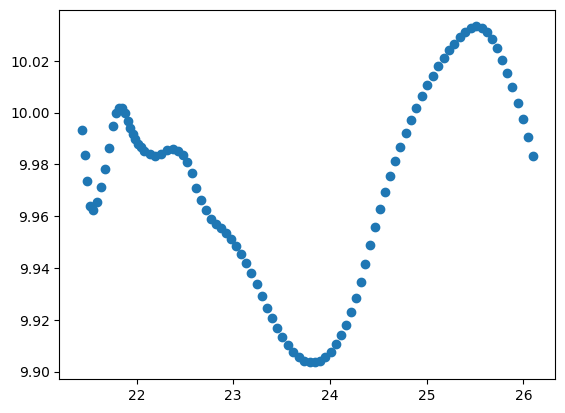

In [8]:
# check the a single agent to see if the data is correct
import matplotlib.pyplot as plt

agent = x[83]

plt.scatter(agent[:, 0], agent[:, 1])

In [9]:
import torch
from torchmetrics.functional import mean_squared_error
from soccertrack.motion_model.models.lstm import SingleTargetLSTM
from soccertrack.motion_model.models.mlp import SingleTargetMLP
from soccertrack.motion_model.models.linear import SingleTargetLinear

print(f"x: {x.shape}")
lstm = SingleTargetLSTM(32)
y_pred = lstm.roll_out(x, y.shape[1])
print(y_pred.shape)

mlp = SingleTargetMLP(input_dim=96*2, hidden_dims=[50, 50, 50], output_dim=2, dropout_prob=0.2)
y_pred = mlp.roll_out(x, y.shape[1])
print(y_pred.shape)

linear = SingleTargetLinear(50)
y_pred = linear.roll_out(x, y.shape[1])
print(y_pred.shape)

x: torch.Size([448, 96, 2])
torch.Size([448, 144, 2])
torch.Size([448, 144, 2])
torch.Size([448, 144, 2])


## Multi-Agent 

In [54]:
from soccertrack.datasets.datasets.trajectory_datamodule import TrajectoryDataset, TrajectoryDataModule

data_dir = trajectory_dataset_path / "F_all"
dm = TrajectoryDataModule(data_dir, single_agent=False, split=96, smooth=True)
dm.setup()

data_loader = dm.train_dataloader()

for batch in data_loader:
    x, y = batch
    break

print(x.shape, y.shape)

torch.Size([32, 96, 22, 2]) torch.Size([32, 144, 22, 2])


In [55]:
from einops import rearrange
def random_ordering(data):
    # randomize and flatten the agent axis
    num_agents = data.shape[2]
    data = data[:, :, torch.randperm(num_agents), :]
    return data

print(x.shape)
random_ordering(x).shape

torch.Size([32, 96, 22, 2])


torch.Size([32, 96, 22, 2])

In [56]:
from soccertrack.motion_model.models.lstm import MultiTargetLSTM
from soccertrack.motion_model.models.gnn import MultiTargetGNN, GCNEncoder

print(f"x: {x.shape}")
lstm = MultiTargetLSTM(44, 32)
y_pred = lstm.forward(x)
y_pred = lstm.roll_out(x, y.shape[1])
print(y_pred.shape)

gnn = MultiTargetGNN(input_channels=96*2, hidden_channels=50, output_channels=2, use_complete_graph=True)
y_pred = gnn.forward(x)
y_pred = gnn.roll_out(x, y.shape[1])
print(y_pred.shape)

mean_squared_error(y_pred, y)

x: torch.Size([32, 96, 22, 2])
torch.Size([32, 144, 22, 2])
torch.Size([32, 144, 22, 2])


tensor(2.3597e+09, grad_fn=<DivBackward0>)

torch.Size([96, 22, 2])


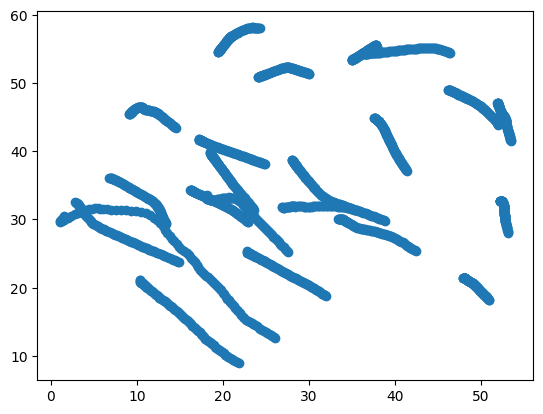

In [22]:
agent = x[0]
plt.scatter(agent[:, :, 0], agent[:, :, 1])
print(agent.shape)

In [8]:
from pytorch_lightning import Trainer
from soccertrack.motion_model.base_module import BaseMotionModule


module = BaseMotionModule(model=lstm, roll_out_steps=144)
module.roll_out(x, y.shape[1])
module.training_step(batch, 0)

tensor(27.1074, grad_fn=<SqrtBackward0>)

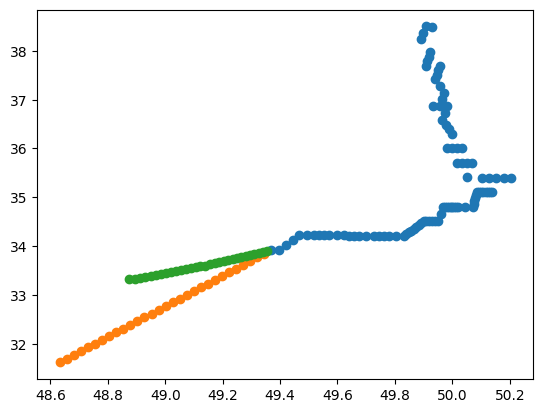

In [94]:
from soccertrack.motion_model.models.linear import SingleTargetLinear

linear = SingleTargetLinear(50)

# # predict velocity using the last 5 frames
v =  x[0, -5:, :].diff(axis=0).mean(axis=0)

# predict the next 30 frames
y_pred = []
for i in range(30):
    y_pred.append(x[0, -1, :] + v * (i+1))

agent = x[0]
plt.scatter(agent[:, 0], agent[:, 1])

y_pred = torch.stack(y_pred)
plt.scatter(y_pred[:, 0], y_pred[:, 1])

y_pred2 = linear.roll_out(x, 30)[0]
plt.scatter(y_pred2[:, 0], y_pred2[:, 1])